# Part 2: Fundamental Matrix Estimation, Camera Calibration, Triangulation

## Fundamental Matrix Estimation

In [3]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

##
## load images and match files for the first example
##

def load_data(img1, img2, match_file):
    I1 = Image.open(img1)
    I2 = Image.open(img2)
    matches = np.loadtxt(match_file)

    # this is a N x 4 file where the first two numbers of each row
    # are coordinates of corners in the first image and the last two
    # are coordinates of corresponding corners in the second image: 
    # matches(i,1:2) is a point in the first image
    # matches(i,3:4) is a corresponding point in the second image

    N = len(matches)
    ##
    ## display two images side-by-side with matches
    ## this code is to help you visualize the matches, you don't need
    ## to use it to produce the results for the assignment
    ##

    I3 = np.zeros((I1.size[1],I1.size[0]*2,3) )
    I3[:,:I1.size[0],:] = I1
    I3[:,I1.size[0]:,:] = I2
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.imshow(np.array(I3).astype(np.uint8))
    ax.plot(matches[:,0],matches[:,1],  '+r')
    ax.plot( matches[:,2]+I1.size[0],matches[:,3], '+g')
    ax.plot([matches[:,0], matches[:,2]+I1.size[0]],[matches[:,1], matches[:,3]], 'b')
    plt.show()
    return I1, I2, matches


In [4]:
##
## display second image with epipolar lines reprojected 
## from the first image
##
def image2homo(points):
    # [N, 2] to [N, 3]
    return np.hstack([points, np.ones((len(points),1))])

def homo2image(points):
    # [N, 3] to [N, 2]
    return np.transpose([points[:, 0]/points[:, 2], points[:, 1]/points[:, 2]])

def normalize(pts):
    center = np.mean(pts, axis=0)
    dist = np.linalg.norm(pts - center, axis=1) ** 2
    mean_dist = np.mean(dist)
    scale = np.sqrt(2 / mean_dist) 
    translation = np.array([[scale, 0, -scale*center[0]], 
                            [0, scale, -scale*center[1]], 
                            [0, 0, 1]])
    homo_pts = image2homo(pts)
    trans_pts = np.matmul(translation, homo_pts.T).T 
    return translation, homo2image(trans_pts)


In [5]:
def fit_fundamental(matches, norm=True):
    left_matches = matches[:, :2]
    right_matches = matches[:, 2:]
    if norm:
        T1, left_matches = normalize(left_matches)
        T2, right_matches = normalize(right_matches)
    num_matches = len(left_matches)
    U = np.zeros((num_matches, 9))
    for i in range(num_matches):
        x1, y1 = left_matches[i][0], left_matches[i][1]
        x2, y2 = right_matches[i][0], right_matches[i][1]
        U[i, 0] = x2 * x1
        U[i, 1] = x2 * y1
        U[i, 2] = x2
        U[i, 3] = y2 * x1
        U[i, 4] = y2 * y1
        U[i, 5] = y2
        U[i, 6] = x1 
        U[i, 7] = y1
        U[i, 8] = 1
    _, _, V = np.linalg.svd(U)
    F_init = V[len(V)-1].reshape(3,3)
    U, S, V = np.linalg.svd(F_init)
    S[-1] = 0
    S = S * np.identity(3)
    F = U.dot(S).dot(V)
    if norm:
        F = T2.T.dot(F).dot(T1)
    # left_homo = image2homo(left_matches)
    # right_homo = image2homo(right_matches)
    # epl = F.dot(left_homo.T).T
    # dl = epl*left_homo
    # epr = F.T.dot(right_homo.T).T
    # dr = epr*right_homo
    # dist = np.square(np.sum(dl, axis=1)/np.linalg.norm(epl[:, :2])) + np.square(np.sum(dr, axis=1)/np.linalg.norm(epr[:, :2]))
    # residual = np.mean(dist)
    # print('residual is:', residual)
    return F
    

In [6]:
def epipolar_projection(I2, matches, norm=True):
    N = len(matches)
    # first, fit fundamental matrix to the matches
    F = fit_fundamental(matches, norm=norm); # this is a function that you should write
    M = np.c_[matches[:,0:2], np.ones((N,1))].transpose()
    L1 = np.matmul(F, M).transpose() # transform points from 
    # the first image to get epipolar lines in the second image

    # find points on epipolar lines L closest to matches(:,3:4)
    l = np.sqrt(L1[:,0]**2 + L1[:,1]**2)
    L = np.divide(L1,np.kron(np.ones((3,1)),l).transpose())# rescale the line
    pt_line_dist = np.multiply(L, np.c_[matches[:,2:4], np.ones((N,1))]).sum(axis = 1)
    print("residual:", np.mean(np.abs(pt_line_dist)))
    closest_pt = matches[:,2:4] - np.multiply(L[:,0:2],np.kron(np.ones((2,1)), pt_line_dist).transpose())

    # find endpoints of segment on epipolar line (for display purposes)
    pt1 = closest_pt - np.c_[L[:,1], -L[:,0]]*10# offset from the closest point is 10 pixels
    pt2 = closest_pt + np.c_[L[:,1], -L[:,0]]*10

    # display points and segments of corresponding epipolar lines
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.imshow(np.array(I2).astype(np.uint8))
    ax.plot(matches[:,2],matches[:,3],  '+r')
    ax.plot([matches[:,2], closest_pt[:,0]],[matches[:,3], closest_pt[:,1]], 'r')
    ax.plot([pt1[:,0], pt2[:,0]],[pt1[:,1], pt2[:,1]], 'g')
    plt.show()

In [7]:
import cv2
from scipy.spatial import distance
 
def sift_descriptor(image):
    sift = cv2.xfeatures2d.SIFT_create()
    # compute descriptors
    kp, dsp = sift.detectAndCompute(image, None)
    pt = cv2.KeyPoint_convert(kp)
    pt = np.array(pt)
    return pt, dsp

def get_matches(dsp1, dsp2, topk=100):
    dist = distance.cdist(dsp1, dsp2, metric="sqeuclidean")
    sort_idx = np.argsort(dist, axis=None)
    match_idx = np.unravel_index(sort_idx,(dist.shape[0], dist.shape[1])) 
    match_idx1 = match_idx[0][:topk]
    match_idx2 = match_idx[1][:topk]
    return np.array([match_idx1, match_idx2]).T
        
def RANSAC(matches, img2, iteration=100, inlier_thres=2):
    max_inlier = 0
    num_matches = matches.shape[0]
    for i in range(iteration):
        select_idx = np.random.choice(range(num_matches), 8)
        select_matches = matches[select_idx]
        F  = fit_fundamental(select_matches, norm=True); 
        M = image2homo(matches[:, :2]).T
        L1 = np.matmul(F, M).T
        
        l = np.sqrt(L1[:,0]**2 + L1[:,1]**2)
        L = np.divide(L1,np.kron(np.ones((3,1)),l).transpose())    # rescale the line
        pt_line_dist = np.multiply(L, np.c_[matches[:,2:4], np.ones((num_matches,1))]).sum(axis = 1)

        inlier_idx = pt_line_dist < inlier_thres
        inliers = matches[inlier_idx]
        
        num_inliers = len(inliers)
        if num_inliers > max_inlier:
            max_inlier = num_inliers
            best_inliers = inliers
    print("max inliers: ", max_inlier)
    
    epipolar_projection(img2, best_inliers, True)
    return

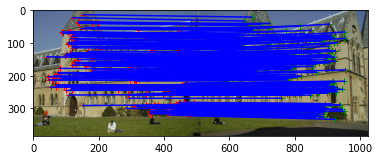

residual: 0.3384950960799586


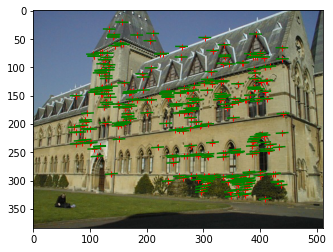

In [8]:
img1 = 'MP3_part2_data/library1.jpg'
img2 = 'MP3_part2_data/library2.jpg'
match_file = 'MP3_part2_data/library_matches.txt'   

I1, I2, matches = load_data(img1, img2, match_file)
epipolar_projection(I2, matches, norm=False)

residual: 0.18359661716193226


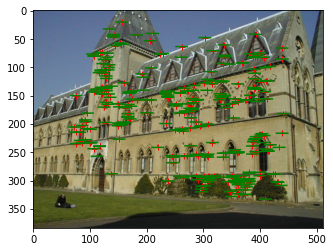

In [9]:
# normalize 
epipolar_projection(I2, matches, norm=True)

max inliers:  47
residual: 12.212905545149148


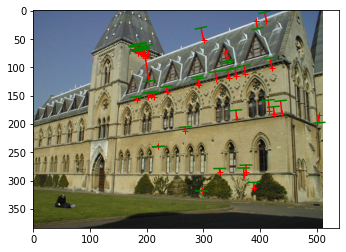

In [11]:
topk = 50
iteration = 50
inlier_thres = 1.5

# ransac to find F
I1_gray = I1.convert("L")
I2_gray = I2.convert("L")
I1_gray = np.asarray(I1_gray)
I2_gray = np.asarray(I2_gray)

filtered_coords1, dsp1 = sift_descriptor(I1_gray)
filtered_coords2, dsp2 = sift_descriptor(I2_gray)
matches = get_matches(dsp1, dsp2, topk)
matched_pt1 = [filtered_coords1[i[0]] for i in matches]
matched_pt2 = [filtered_coords2[i[1]] for i in matches]
matched_pt = np.hstack([matched_pt1, matched_pt2])

RANSAC(matched_pt, I2, iteration, inlier_thres)

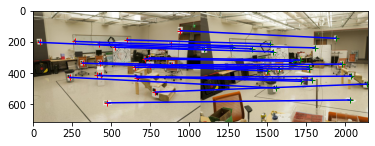

residual: 2.237977425348351


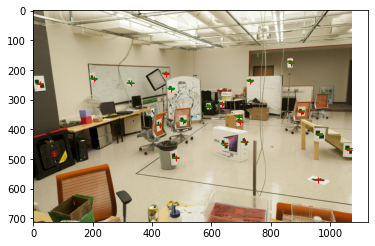

residual: 0.6172517559032379


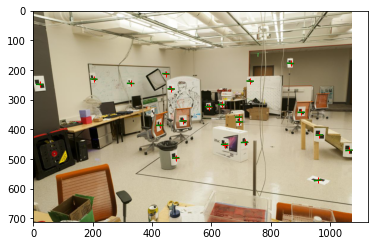

In [13]:
img1 = 'MP3_part2_data/lab1.jpg'
img2 = 'MP3_part2_data/lab2.jpg'
match_file = 'MP3_part2_data/lab_matches.txt'   

I1, I2, matches = load_data(img1, img2, match_file)
epipolar_projection(I2, matches, norm=False)
epipolar_projection(I2, matches, norm=True)

## Camera Calibration

In [14]:
def evaluate_points(M, points_2d, points_3d):
    """
    Visualize the actual 2D points and the projected 2D points calculated from
    the projection matrix
    You do not need to modify anything in this function, although you can if you
    want to
    :param M: projection matrix 3 x 4
    :param points_2d: 2D points N x 2
    :param points_3d: 3D points N x 3
    :return:
    """
    N = len(points_3d)
    points_3d = np.hstack((points_3d, np.ones((N, 1))))
    points_3d_proj = np.dot(M, points_3d.T).T
    u = points_3d_proj[:, 0] / points_3d_proj[:, 2]
    v = points_3d_proj[:, 1] / points_3d_proj[:, 2]
    residual = np.sum(np.hypot(u-points_2d[:, 0], v-points_2d[:, 1]))
    points_3d_proj = np.hstack((u[:, np.newaxis], v[:, np.newaxis]))
    return points_3d_proj, residual

In [21]:
def get_projection(point3d, point2d):
    n = point3d.shape[0]
    A = np.zeros((n*2, 12))
    pt3d_homo = image2homo(point3d)
    for i in range(n):
        X = pt3d_homo[i]
        x, y = point2d[i][0], point2d[i][1]
        A[i*2, 4:8] = X
        A[i*2, 8:] = -y * X
        A[i*2+1, :4] = X
        A[i*2+1, 8:] = -x * X
    _, _, V = np.linalg.svd(A)
    M = V[len(V)-1].reshape(3, 4)
    return M

In [15]:
def camera_calib(matches, point3d):
    left_matches = matches[:, :2]
    right_matches = matches[:, 2:]
    left_M = get_projection(point3d, left_matches)
    right_M = get_projection(point3d, right_matches)
    pt3d_left, resi_left = evaluate_points(left_M, left_matches, point3d)
    print('Left image camera calibration redisual: ', resi_left)
    pt3d_right, resi_right = evaluate_points(right_M, right_matches, point3d)
    print('Right image camera calibration redisual: ', resi_right)
    return left_M, right_M


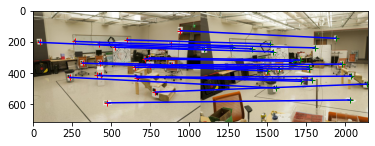

Left image camera calibration redisual:  13.545832900248698
Right image camera calibration redisual:  15.544953457947923


In [30]:
img1 = 'MP3_part2_data/lab1.jpg'
img2 = 'MP3_part2_data/lab2.jpg'
match_file = 'MP3_part2_data/lab_matches.txt'
pt3d_file = "MP3_part2_data/lab_3d.txt"   

I1, I2, matches = load_data(img1, img2, match_file)
point3d = np.loadtxt(pt3d_file)
lab_left_M, lab_right_M = camera_calib(matches, point3d)

## Camera Centers

In [35]:
from scipy.linalg import null_space

center_left = null_space(lab_left_M)
center_left_lab = center_left/center_left[-1] # homo 2 image
print('Left lab cam center:', center_left_lab)
center_right = null_space(lab_right_M)
center_right_lab = center_right/center_right[-1]
print('Right lab cam center:', center_right_lab)

Left lab cam center: [[305.83276769]
 [304.20103826]
 [ 30.13699243]
 [  1.        ]]
Right lab cam center: [[303.10003925]
 [307.18428016]
 [ 30.42166874]
 [  1.        ]]


In [36]:
library_left_M = np.loadtxt('MP3_part2_data/library1_camera.txt')
library_right_M = np.loadtxt('MP3_part2_data/library2_camera.txt')
center_left = null_space(library_left_M)
center_left_library = center_left/center_left[-1]
print('Left library cam center:', center_left_lab)
center_right = null_space(library_right_M)
center_right_library = center_right/center_right[-1]
print('Right libray cam center:', center_right_library)

Left library cam center: [[305.83276769]
 [304.20103826]
 [ 30.13699243]
 [  1.        ]]
Right libray cam center: [[  6.89405488]
 [-15.39232716]
 [ 23.41498687]
 [  1.        ]]


## Triangulation

In [40]:
def triangulate(P1, P2, matches):
    num_match = matches.shape[0]
    x1 = image2homo(matches[:, :2])
    x2 = image2homo(matches[:,2:])
    
    X = np.zeros((num_match, 4))
    for i in range(num_match):
        x1x = np.array([[0, -x1[i, 2], x1[i, 1]],
                        [x1[i, 2], 0, -x1[i, 0]],
                        [-x1[i, 1], x1[i, 0], 0]])
        x2x = np.array([[0, -x2[i, 2], x2[i, 1]],
                        [x2[i, 2], 0, -x2[i, 0]],
                        [-x2[i, 1], x2[i, 0], 0]])  
        
        A1 = np.matmul(x1x, P1)
        A2 = np.matmul(x2x, P2)
        A = np.vstack((A1, A2))

        _, _, V = np.linalg.svd(A)
        Xi = V[len(V)-1]
        X[i] = Xi / Xi[-1]
    return X

def get_residual(P1, P2, X, matches):
    left_proj = np.matmul(P1, X.T).T
    right_proj = np.matmul(P2, X.T).T
    left_x = homo2image(left_proj)
    right_x = homo2image(right_proj)
    left_resi = np.linalg.norm(left_x - matches[:, :2]) ** 2 
    right_resi = np.linalg.norm(right_x-matches[:, 2:]) ** 2 
    resi = (left_resi + right_resi) / (2 * len(matches))
    return resi

In [46]:
def plot3d(X, center_left, center_right):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(30, 50)
    ax.scatter(X[:, 0], X[:, 1], X[:, 2])
    ax.scatter(center_left[0], center_left[1], center_left[2], '+r')
    ax.scatter(center_right[0], center_right[1], center_right[2], '+g')

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    plt.show()

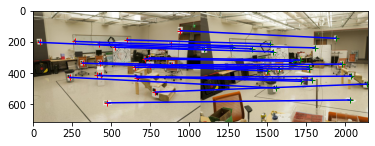

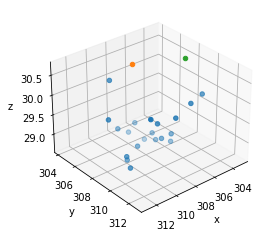

residual:  1.0318213201651718
[[-3.09963996e-03 -1.46204548e-04  4.48497465e-04  9.78930678e-01]
 [-3.07018252e-04 -6.37193664e-04  2.77356178e-03  2.04144405e-01]
 [-1.67933533e-06 -2.74767684e-06  6.83964827e-07  1.32882928e-03]]
[[ 6.93154686e-03 -4.01684470e-03 -1.32602928e-03 -8.26700554e-01]
 [ 1.54768732e-03  1.02452760e-03 -7.27440714e-03 -5.62523256e-01]
 [ 7.60946050e-06  3.70953989e-06 -1.90203244e-06 -3.38807712e-03]]


In [49]:
img1 = 'MP3_part2_data/lab1.jpg'
img2 = 'MP3_part2_data/lab2.jpg'
match_file = 'MP3_part2_data/lab_matches.txt' 

I1, I2, matches = load_data(img1, img2, match_file)
X = triangulate(lab_left_M, lab_right_M, matches)
plot3d(X, center_left_lab, center_right_lab)
resi = get_residual(lab_left_M, lab_right_M, X, matches)
print("residual: ", resi)
print(lab_left_M)
print(lab_right_M)


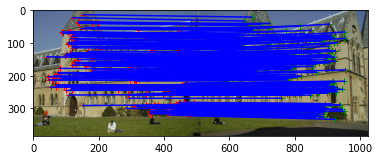

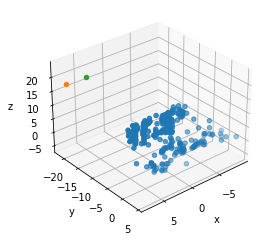

residual:  0.17040373843022627


In [47]:
img1 = 'MP3_part2_data/library1.jpg'
img2 = 'MP3_part2_data/library2.jpg'
match_file = 'MP3_part2_data/library_matches.txt' 

I1, I2, matches = load_data(img1, img2, match_file)
X = triangulate(library_left_M, library_right_M, matches)
plot3d(X, center_left_library, center_right_library)
resi = get_residual(library_left_M, library_right_M, X, matches)
print("residual: ", resi)